In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/DL/Ex_5/titanic.zip' 


Archive:  /content/drive/My Drive/Colab Notebooks/DL/Ex_5/titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


Importando conjunto de treino:

In [ ]:
df = pd.read_csv('/content/train.csv')

print(list(df))
print(df.shape)


['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
(891, 12)


# **Definindo Funções:**

Função para criar a matrix de confusão:

In [ ]:
from sklearn.metrics import confusion_matrix

def c_matrix(y_true,y_pred):
  
  classes = ['Survived','Not Survived']

  cm = confusion_matrix(y_true, y_pred)

  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels') 
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes) 
  ax.yaxis.set_ticklabels(classes);

#minimize false positive seems more important

Função para plotar a loss e acurácia gerados no treino:

In [ ]:
def plot_history(model_fit):

  print(model_fit.history.keys())
  # summarize history for accuracy
  plt.plot(model_fit.history['accuracy'])
  plt.plot(model_fit.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  
  # summarize history for loss
  plt.plot(model_fit.history['loss'])
  plt.plot(model_fit.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


# **Pré-Processamento dos Dados:**

Verificando se há linhas duplicadas:

In [ ]:
# calculate duplicates
dups = df.duplicated()
# report if there are any duplicates
print(df.duplicated().any())
# list all duplicate rows
print(df[dups])

False
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Cabin, Embarked]
Index: []


Contando valores únicos para cada coluna:

In [ ]:
from numpy import unique

for i in list(df):
	print(i,len(df[i].unique()))

PassengerId 891
Survived 2
Pclass 3
Name 891
Sex 2
Age 89
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 148
Embarked 4


Contando valores faltantes:

In [ ]:
print(df.shape)
print(df.isna().sum())

(891, 12)
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### **Preenchendo Valores Faltantes para Idade**

Os valores faltantes para idade serão preenchidos de acordo com a mediana da distribuição de idades associada a titulação dos passageiros. Abaixo, extraímos os títulos dos nomes, e criamos uma coluna com esses títulos referentes a cada passageiro:

In [ ]:
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=True)
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'Countess',
       'Jonkheer'], dtype=object)

Em seguida, substituímos os valores faltates das idades pela mediana da distribuição das idades referente a cada título: 

In [ ]:
for title, age in df.groupby('Title')['Age'].median().iteritems():
    print(title, age)
    df.loc[(df['Title']==title) & (df['Age'].isnull()), 'Age'] = age

Capt 70.0
Col 58.0
Countess 33.0
Don 40.0
Dr 46.5
Jonkheer 38.0
Lady 48.0
Major 48.5
Master 3.5
Miss 21.0
Mlle 24.0
Mme 24.0
Mr 30.0
Mrs 35.0
Ms 28.0
Rev 46.5
Sir 49.0


### **Dropping Values**

A coluna 'Cabin' possui mais de 70% dos valores faltantes, por isso será excluída. Consideramos que as colunas 'Name' e 'PassengengerId' não serão relevantes para as predições, portanto serão excluidas. As colunas 'Ticket' e 'Title' serão excluidas pois, de acordo com os resultados da validação, pioram a performance do modelo:


In [ ]:
#deleting columns: 'Cabin', 'Name' and 'PassengerId'
df_drop = df.drop(columns=['Name','Cabin','PassengerId','Ticket','Title'])

#deleting 2 rows with missing values on 'Embarked' column
df_drop = df_drop.dropna(subset=['Embarked'])

#verifying presence of missing values
print(df_drop.isna().sum())
print(df_drop.shape)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
(889, 8)



### **Encoding and Scaling Data**

Processando valores categóricos:

In [ ]:
from sklearn import preprocessing

#onehot encoding columns 'Sex', 'Embarked' and 'Pclass'
data_encoded = pd.get_dummies(df_drop, columns = ['Sex','Embarked','Pclass'])

Reescalando dados 'Fare' e 'Age':

In [ ]:
#reescaling 'Fare' and 'Age'

data_encoded[['Fare','Age']] = preprocessing.StandardScaler().fit_transform(data_encoded[['Fare','Age']])

Plotando matriz de correlação entre os dados:

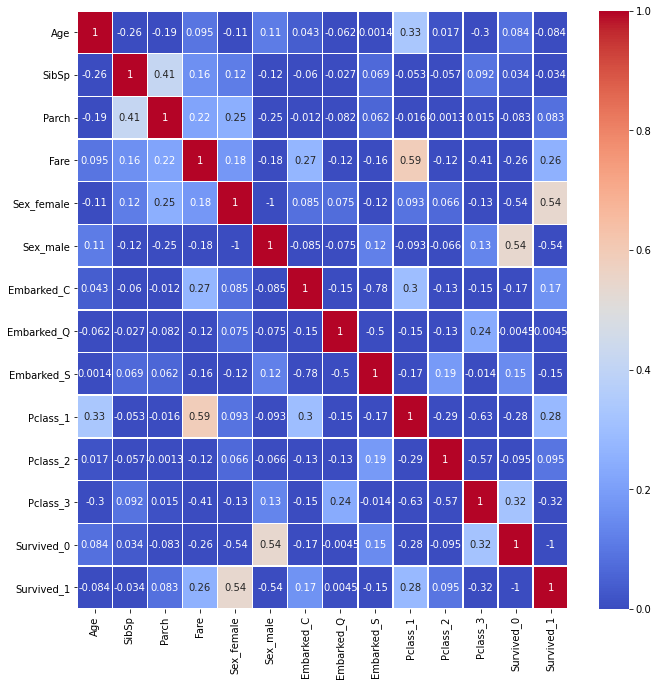

In [ ]:
#features used on heat map

df_heat = pd.get_dummies(data_encoded, columns = ['Survived'])

corr = df_heat.corr()
fig, ax = plt.subplots(figsize=(11,11)) 
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        vmin=0, vmax=1,
        cmap="coolwarm",
        linewidths=.5,
        annot=True, 
        ax=ax
        )
plt.show()

In [ ]:
print(pd.get_dummies(data_encoded['Survived']))
print((data_encoded['Survived']))

     0  1
0    1  0
1    0  1
2    0  1
3    0  1
4    1  0
..  .. ..
886  1  0
887  0  1
888  1  0
889  0  1
890  1  0

[889 rows x 2 columns]
0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64


### **Separação dos Dados**

Separando dados em conjuntos de treino e validação:

In [ ]:
from sklearn.model_selection import train_test_split

X = data_encoded.drop(columns = ['Survived'])
y = data_encoded['Survived']

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y, 
    stratify=y, 
    test_size=0.2, 
    random_state=32)


# **Configurando Modelo**

Rede Neural Sequencial:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization, Activation
from keras.regularizers import l1

model = Sequential([
  Dense(64, activation='relu', activity_regularizer=l1(0.0001)),
  Activation('relu'),
  BatchNormalization(),
  #Dropout(0.3),
  Dense(32, activation='relu'),
  #BatchNormalization(),
  Dropout(0.3),
  Dense(32, activation='relu'),
  BatchNormalization(),
  #Dropout(0.2),
   Dense(2, activation='softmax'),
])


Compilando:

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(
  optimizer=opt,
  loss='categorical_crossentropy',
  metrics='accuracy',
)

Treinando o modelo e avaliando a performance:


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


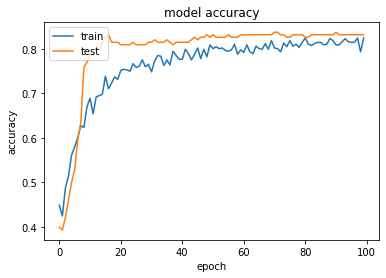

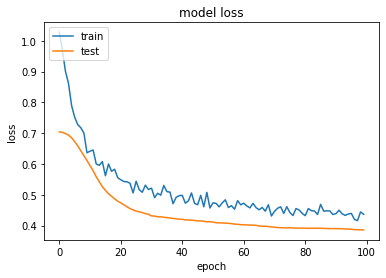

In [ ]:
from tensorflow.keras.utils import to_categorical

history = model.fit(
  X_train,to_categorical(y_train),
  epochs=100,
  validation_data = (X_val,to_categorical(y_val)),
  batch_size = 32,
  verbose=0
)

plot_history(history)

Salvando os pesos:

In [ ]:
model.save_weights('/content/model.h5') #saving model to disk


# **Avaliando a Performance**
### **Cross-Validation:**

In [ ]:
from sklearn.model_selection import KFold


#loading model's weight (defined on prediction section):

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

weights_cv = '/content/model.h5'


for train, test in kfold.split(X, y):

  model_cv = model

  model_cv.load_weights(weights_cv)

  model_cv.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics='accuracy',
  )

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  model_cv.fit(
        X.iloc[train],
        to_categorical(y.iloc[train]),
        epochs=100,
        batch_size = 32,
        verbose=0
      )

  # Generate generalization metrics
  scores = model_cv.evaluate(X.iloc[test],to_categorical(y.iloc[test]))
  print(f'Score for fold {fold_no}: {model_cv.metrics_names[0]} of {scores[0]}; {model_cv.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1


------------------------------------------------------------------------
Training for fold 1 ...
3/3 [==============================] - 0s 2ms/step - loss: 0.3594 - accuracy: 0.8427
Score for fold 1: loss of 0.35939693450927734; accuracy of 84.26966071128845%
------------------------------------------------------------------------
Training for fold 2 ...
3/3 [==============================] - 0s 3ms/step - loss: 0.4663 - accuracy: 0.8090
Score for fold 2: loss of 0.4663206934928894; accuracy of 80.89887499809265%
------------------------------------------------------------------------
Training for fold 3 ...
3/3 [==============================] - 0s 2ms/step - loss: 0.5049 - accuracy: 0.8315
Score for fold 3: loss of 0.5049459338188171; accuracy of 83.14606547355652%
------------------------------------------------------------------------
Training for fold 4 ...
3/3 [==============================] - 0s 3ms/step - loss: 0.4669 - accuracy: 0.8090
Score for fold 4: loss of 0.466906934976

In [ ]:

# Printing average score for each fold
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('-----------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.35939693450927734 - Accuracy: 84.26966071128845%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4663206934928894 - Accuracy: 80.89887499809265%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5049459338188171 - Accuracy: 83.14606547355652%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.46690693497657776 - Accuracy: 80.89887499809265%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5484333038330078 - Accuracy: 75.28089880943298%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.3856138586997986 - Accuracy: 80.89887499809265%
----------------------------------------------------------------------

### **Confusion Matrix**

Previsão dos valores a partir do conjunto de validação:

In [ ]:
model.load_weights('model.h5')

In [ ]:
prediction = model.predict(X_val)

Plotting confusion matrix for Neural Network predictions:

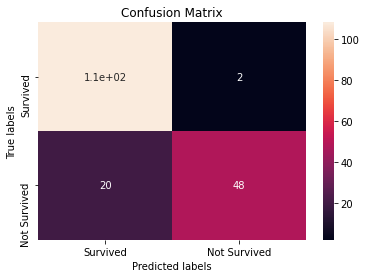

In [ ]:

c_matrix(np.array(y_val),np.argmax(prediction, axis=1))


### **Curva ROC**

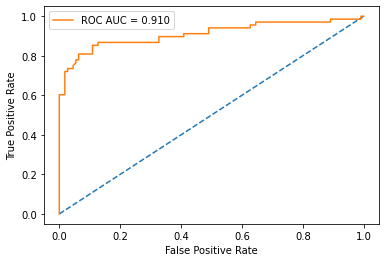

In [ ]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

ns_probs = [0 for _ in range(len(y_val))]
# fit a model

# predict probabilities
lr_probs = prediction
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_val, ns_probs)
lr_auc = roc_auc_score(y_val, lr_probs)

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_val, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_val, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--')
pyplot.plot(lr_fpr, lr_tpr, label=f'ROC AUC = {lr_auc:0.3f}')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# **Predição para o Conjunto de Teste**

In [ ]:
df_test = pd.read_csv('/content/test.csv')

Contando valores faltantes:

In [ ]:
print(df_test.isna().sum())
print(df_test.shape)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
(418, 11)


Preenchendo valores faltantes para idade, usando mesmo método aplicado ao conjunto de treino, mas a partir dos dados do conjunto de teste:



In [ ]:
df_test['Title'] = df_test['Name'].str.extract('([A-Za-z]+)\.', expand=True)
print(df_test['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


In [ ]:
#substitute Ms by Miss
df_test['Title'] = df_test['Title'].replace('Ms','Miss')

#replacing age missing values 
for title, age in df_test.groupby('Title')['Age'].median().iteritems():
    print(title, age)
    df_test.loc[(df_test['Title']==title) & (df_test['Age'].isnull()), 'Age'] = age

Col 50.0
Dona 39.0
Dr 53.0
Master 7.0
Miss 22.0
Mr 28.5
Mrs 36.5
Rev 35.5


Excluindo colunas:

In [ ]:
df_test_drop = df_test.drop(columns=['Name','Cabin','PassengerId','Ticket','Title'])

Preenchendo o restante dos valores faltantes:

In [ ]:
#filling 'Fare' single missing value with 0
data_test = df_test_drop.fillna(0)
print(data_test.isna().isna().sum())
print(data_test.shape)

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
(418, 7)


### **Encoding and Scaling Data**

Processando dados categóricos do conjunto de teste:

In [ ]:
#onehot encoding comuns: 'Sex','Embarked' and 'Pclass'
data_test_encoded = pd.get_dummies(data_test, columns = ['Sex','Embarked','Pclass'])


Reescalando dados 'Fare' e 'Age':

In [ ]:
data_test_encoded[['Age','Fare']] = preprocessing.StandardScaler().fit_transform(data_test_encoded[['Age','Fare']])

# **Prevendo e Salvando Valores para o Conjunto de Teste**

Prevendo valores:

In [ ]:
predictions_test = model.predict(data_test_encoded)



Salvando predições em um arquivo *.csv:

In [ ]:
output = pd.DataFrame({'PassengerId': [df_test['PassengerId'].iloc[i] for i in range(len(df_test['PassengerId']))], 'Survived': np.argmax(predictions_test, axis=1)})
output.to_csv('submission.csv', index=False)

In [ ]:
sub = pd.read_csv('/content/submission.csv')
print(sub)


     PassengerId  Survived
0            892         0
1            893         0
2            894         0
3            895         0
4            896         0
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]
